# 训练配置修改

配置文件完整版如下：

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import torch
from datasets import load_dataset
from mmengine.dataset import DefaultSampler
from mmengine.hooks import (CheckpointHook, DistSamplerSeedHook, IterTimerHook,
                            LoggerHook, ParamSchedulerHook)
from mmengine.optim import AmpOptimWrapper, CosineAnnealingLR, LinearLR
from peft import LoraConfig
from torch.optim import AdamW
from transformers import (AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig)

from xtuner.dataset import process_hf_dataset
from xtuner.dataset.collate_fns import default_collate_fn
from xtuner.dataset.map_fns import oasst1_map_fn, template_map_fn_factory
from xtuner.engine.hooks import (DatasetInfoHook, EvaluateChatHook,
                                 VarlenAttnArgsToMessageHubHook)
from xtuner.engine.runner import TrainLoop
from xtuner.model import SupervisedFinetune
from xtuner.utils import PROMPT_TEMPLATE

#######################################################################
#                          PART 1  Settings                           #
#######################################################################
# Model
# 设置 LLM 路径或 HuggingFace Hub ID
pretrained_model_name_or_path = 'internlm/internlm2-chat-7b'
use_varlen_attn = False  # 是否使用 varlen_attention

# Data
# 设置 dataset 路径或 HuggingFace Hub ID，以用于 datasets.load_dataset
data_path = 'timdettmers/openassistant-guanaco'
prompt_template = PROMPT_TEMPLATE.internlm2_chat  # 设置对话模版
max_length = 2048  # 设置训练数据截断长度
pack_to_max_length = True  # 是否将多条样本打包为一条最长长度的样本

# Scheduler & Optimizer
batch_size = 1  # per_device  # 每个设备的样本个数
accumulative_counts = 16  # 梯度累计数
dataloader_num_workers = 0  # dataloader worker 数
max_epochs = 3  # 训练迭代代数
optim_type = AdamW  # 优化器
lr = 2e-4  # 学习率
betas = (0.9, 0.999)  # AdamW 优化器 betas
weight_decay = 0  # AdamW 优化器权重衰减
max_norm = 1  # grad clip  # 梯度裁剪
warmup_ratio = 0.03  # warmup 比率

# Save
save_steps = 500  # checkpoint 保存间隔（iter 数）
save_total_limit = 2  # 最大保存 checkpoint 个数，-1 表示无限制

# Evaluate the generation performance during the training
evaluation_freq = 500  # 验证对话效果的执行间隔（iter 数）
SYSTEM = ''  # 验证对话效果的 system 字段
evaluation_inputs = [  # 验证对话效果时的测试问题
    '请给我介绍五个上海的景点', 'Please tell me five scenic spots in Shanghai'
]

#######################################################################
#                      PART 2  Model & Tokenizer                      #
#######################################################################
tokenizer = dict(  # 构建 tokenizer
    type=AutoTokenizer.from_pretrained,
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    trust_remote_code=True,
    padding_side='right')

model = dict(  # 构建 model
    type=SupervisedFinetune,
    use_varlen_attn=use_varlen_attn,
    llm=dict(  # 构建 LLM
        type=AutoModelForCausalLM.from_pretrained,
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        trust_remote_code=True,
        torch_dtype=torch.float16,
        quantization_config=dict(  # 量化配置（保留则为 4 比特，删除则为正常浮点）
            type=BitsAndBytesConfig,
            load_in_4bit=True,
            load_in_8bit=False,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4')),
    lora=dict(  # LoRA 配置（保留则使用 LoRA 微调，删除则使用全量微调）
        type=LoraConfig,
        r=64,
        lora_alpha=16,
        lora_dropout=0.1,
        bias='none',
        task_type='CAUSAL_LM'))

#######################################################################
#                      PART 3  Dataset & Dataloader                   #
#######################################################################
train_dataset = dict(  # 构建训练数据集
    type=process_hf_dataset,
    # 调用 datasets.load_dataset 接口
    dataset=dict(type=load_dataset, path=data_path),
    tokenizer=tokenizer,
    max_length=max_length,
    dataset_map_fn=oasst1_map_fn,  # 选择匹配的数据集 map_fn
    template_map_fn=dict(
        type=template_map_fn_factory, template=prompt_template),
    remove_unused_columns=True,
    shuffle_before_pack=True,
    pack_to_max_length=pack_to_max_length,
    use_varlen_attn=use_varlen_attn)

train_dataloader = dict(  # 构建训练数据集的 DataLoader
    batch_size=batch_size,
    num_workers=dataloader_num_workers,
    dataset=train_dataset,
    sampler=dict(type=DefaultSampler, shuffle=True),
    collate_fn=dict(type=default_collate_fn, use_varlen_attn=use_varlen_attn))

#######################################################################
#                    PART 4  Scheduler & Optimizer                    #
#######################################################################
# optimizer
optim_wrapper = dict(  # 构建优化器
    type=AmpOptimWrapper,
    optimizer=dict(
        type=optim_type, lr=lr, betas=betas, weight_decay=weight_decay),
    clip_grad=dict(max_norm=max_norm, error_if_nonfinite=False),
    accumulative_counts=accumulative_counts,
    loss_scale='dynamic',
    dtype='float16')

# learning policy
# More information: https://github.com/open-mmlab/mmengine/blob/main/docs/en/tutorials/param_scheduler.md  # noqa: E501
param_scheduler = [  # 设置学习率 scheduler
    dict(
        type=LinearLR,  # warmup 阶段
        start_factor=1e-5,
        by_epoch=True,
        begin=0,
        end=warmup_ratio * max_epochs,
        convert_to_iter_based=True),
    dict(
        type=CosineAnnealingLR,  # Cosine 学习率衰减阶段
        eta_min=0.0,
        by_epoch=True,
        begin=warmup_ratio * max_epochs,
        end=max_epochs,
        convert_to_iter_based=True)
]

# train, val, test setting
train_cfg = dict(type=TrainLoop, max_epochs=max_epochs)  # 设置训练迭代代数

#######################################################################
#                           PART 5  Runtime                           #
#######################################################################
# Log the dialogue periodically during the training process, optional
custom_hooks = [  # 定义 Hooks
    dict(type=DatasetInfoHook, tokenizer=tokenizer),  # 在训练前打印可视化打印数据样本
    dict(
        type=EvaluateChatHook,  # 在训练时测试对话效果
        tokenizer=tokenizer,
        every_n_iters=evaluation_freq,
        evaluation_inputs=evaluation_inputs,
        system=SYSTEM,
        prompt_template=prompt_template)
]

if use_varlen_attn:
    # vallen_attention 依赖的 Hook
    custom_hooks += [dict(type=VarlenAttnArgsToMessageHubHook)]

# 以下均为默认配置，如需调整请参考 MMEngine 文档及代码

# configure default hooks
default_hooks = dict(
    # record the time of every iteration.
    timer=dict(type=IterTimerHook),
    # print log every 10 iterations.
    logger=dict(type=LoggerHook, log_metric_by_epoch=False, interval=10),
    # enable the parameter scheduler.
    param_scheduler=dict(type=ParamSchedulerHook),
    # save checkpoint per `save_steps`.
    checkpoint=dict(
        type=CheckpointHook,
        by_epoch=False,
        interval=save_steps,
        max_keep_ckpts=save_total_limit),
    # set sampler seed in distributed evrionment.
    sampler_seed=dict(type=DistSamplerSeedHook),
)

# configure environment
env_cfg = dict(
    # whether to enable cudnn benchmark
    cudnn_benchmark=False,
    # set multi process parameters
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    # set distributed parameters
    dist_cfg=dict(backend='nccl'),
)

# set visualizer
visualizer = None

# set log level
log_level = 'INFO'

# load from which checkpoint
load_from = None

# whether to resume training from the loaded checkpoint
resume = False

# Defaults to use random seed and disable `deterministic`
randomness = dict(seed=None, deterministic=False)

# set log processor
log_processor = dict(by_epoch=False)

常用修改的配置如下：
- 模型：pretrained_model_name_or_path
- 提示词模板：prompt_template
- 微调类型：lora、qlora和全量微调
- 数据集
- 优化器
- 迭代次数
- 保存checkpoint的间隔
- 保存checkpoint的最大数量
- 调整对话评测间隔
- 调整对话评测的 system 字段
- 调整对话评测的测试指令

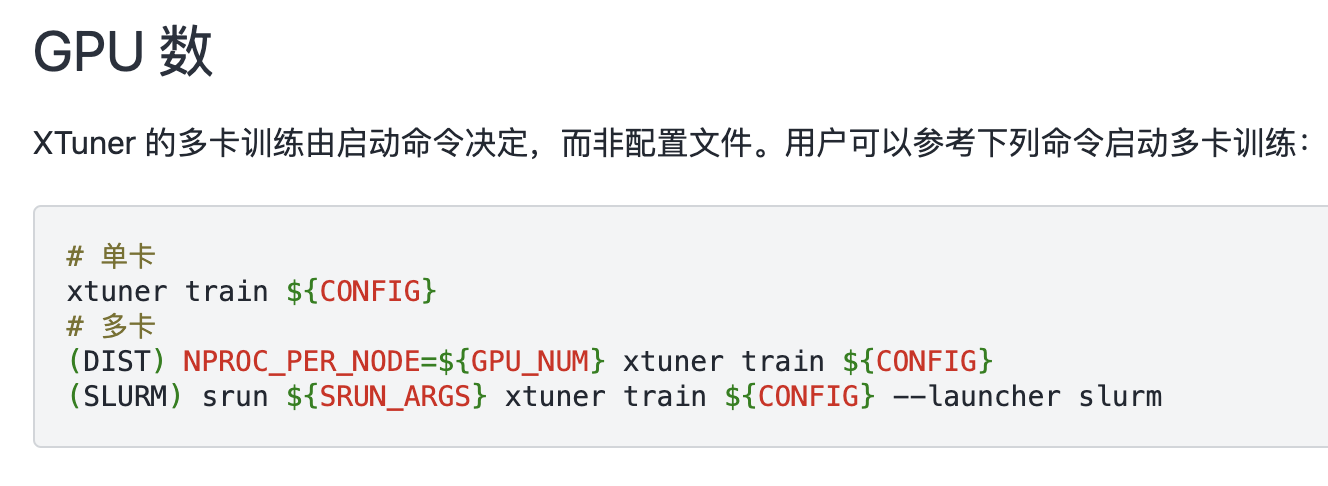

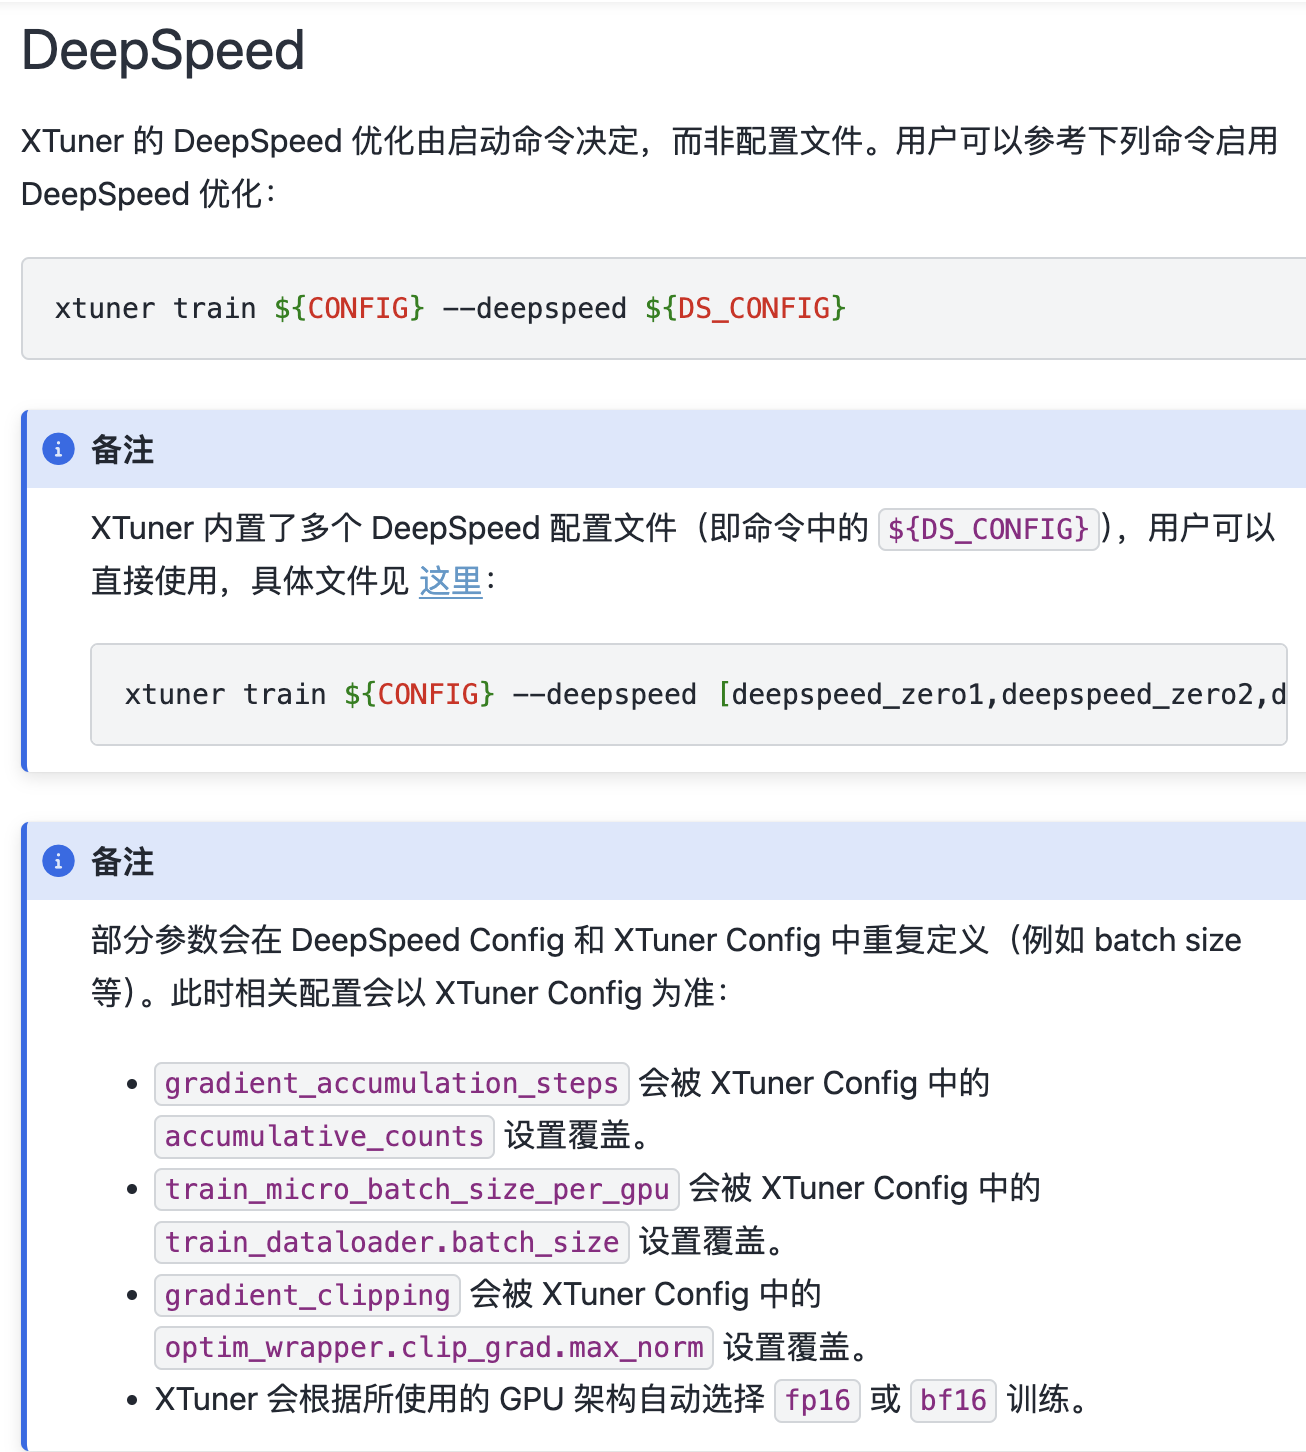

qlora微调
```
model = dict(
      ......
      llm=dict(
         type=AutoModelForCausalLM.from_pretrained,
         pretrained_model_name_or_path=pretrained_model_name_or_path,
         trust_remote_code=True,
         torch_dtype=torch.float16,
         quantization_config=dict(
            type=BitsAndBytesConfig,
            load_in_4bit=True,
            load_in_8bit=False,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4')),
      lora=dict(
         type=LoraConfig,
         r=64,
         lora_alpha=16,
         lora_dropout=0.1,
         bias='none',
         task_type='CAUSAL_LM'),
      ......)
```

lora微调
```
model = dict(
      ......
      llm=dict(
         type=AutoModelForCausalLM.from_pretrained,
         pretrained_model_name_or_path=pretrained_model_name_or_path,
         trust_remote_code=True,
         torch_dtype=torch.float16,
         quantization_config=None),
      lora=dict(
         type=LoraConfig,
         r=64,
         lora_alpha=16,
         lora_dropout=0.1,
         bias='none',
         task_type='CAUSAL_LM'),
      ......)
```

全参数微调  
将 lora 和 quantization_config 都设置为 None，就切换到了全参数训练模式
```
model = dict(
      ......
      llm=dict(
         type=AutoModelForCausalLM.from_pretrained,
         pretrained_model_name_or_path=pretrained_model_name_or_path,
         trust_remote_code=True,
         torch_dtype=torch.float16,
         quantization_config=None),
      lora=None,
      ......)
```